# Finite difference test

**Motivation:** Since alchemical derviative on forces $\partial_\lambda\langle\psi|\partial_{\mathbf{R}_I}H_\lambda|\psi\rangle$ is not implement, finite difference is necessary at the moment. Instead of performing ~$N$ finite difference on fource, $\partial_{\mathbf{R}_I}\mathbf{F}_J=\big(\partial_{R_{Ii}}F_{Jj}\big)_{ij}$, each ~$N^2$ Hessian matrix element must be computed by second order finite difference $\partial^2_{R_{Ii}R_{Jj}} E$. 

The setup is the following: The eigenvalues of Hessian matrix should be estimated for a target system $H^{\rm tar}$. We estimate the Hessian matrix from a reference system $H^{\rm ref}$ and the corresponding alchemical derivative $\partial_\lambda E^{{\rm ref}\rightarrow{\rm tar}}$. That is
$$
\big(\partial^2_{R_{Ii}R_{Jj}} E^{\rm tar}\big)_{IiJj} \approx \big(\partial^2_{R_{Ii}R_{Jj}} E^{\rm pred}\big)_{IiJj} = \big(\partial^2_{R_{Ii}R_{Jj}} E^{\rm ref}\big)_{IiJj} + \big(\partial^2_{R_{Ii}R_{Jj}} \partial_\lambda E^{{\rm ref}\rightarrow{\rm tar}}\big)_{IiJj}.
$$
The alchemical derivative is evaluated analytically while the second order derivative of Hessian matrix element is evalutated numerically by finite difference,

$$
\partial^2_{R_{Ii}R_{Jj}} E = \lim_{\Delta h, \Delta l\rightarrow 0}\frac{E(\cdots, R_{Ii}+\Delta h, \cdots, R_{Jj} + \Delta l, \cdots) - E(\cdots, R_{Ii}, \cdots, R_{Jj}, \cdots)}{\Delta h \Delta l}.
$$

By doing this, the alchemical prediction to phonon frequency is computed by diagonalizing $\big(\partial^2_{R_{Ii}R_{Jj}} E^{\rm pred}\big)_{IiJj}$

Therefore it is crucial to examine the predictive error of each Hessian matrix element made by alchemical prediction.

**Plan:** Use pure graphene of $2\times 2\times 1$ supercell of 8 atoms with perfect hony cone structure as reference. Target systems are the system doped by one B-N pair, BN1 with with a BN bond, and BN2 where B and N are separated by a single C.

**Method:** Constuct list containing all possibility of [{ij}, {IJ}], where I, J run through all nuclie and i, j run through x, y ,z directions. For example, the list should look like [{xx, xy, xz, yy, yz}, {11, 12, ..., 22, 23, ...}]. Randomize the list and perform reference runs, and predictions in order. Ideally, each entry of the list will provide some points to the scatter plot.

**Validation:** Eigenvalues of the matrix $[\partial^2_{R_{Ii}R_{Jj}} E]_{IiJj}$ for the reference systems should be compared with the result of frozen phonon approximation implemented in standard code

In [1]:
# https://github.com/SamKChang/qctoolkit
import qctoolkit as qtk 
import numpy as np
import matplotlib as mtp
from matplotlib import pyplot as plt
from datetime import datetime
import copy

plt.style.use('classic')

%matplotlib inline

# Construct graphene

In [2]:
a = 1.42 # bond length

# hard coded geometry of perfect hony cone structure
R_scale = np.array([[1./3., 1./3., 0], [2./3., 2./3., 0]])
lattice = np.array([[1, 0, 0], [.5, np.sqrt(3)/2, 0], [0, 0, 5]]) * np.sqrt(3) * a

# necessary variables for periodic systems
celldm = qtk.lattice2celldm(lattice)
Z = [[6], [6]]
R = np.dot(R_scale, lattice)
ZR = np.hstack([Z, R])

# biuld molecule object for periodic graphene
mol = qtk.Molecule()
mol.build(ZR)

mol.R_scale = R_scale
mol.celldm = celldm
mol.lattice = lattice
mol.periodic = True

In [3]:
# check results
mol_ext = mol.copy()
mol_ext.extend([2,2,1], normalize=True)
mol_ext.write('test.xyz')
mol_ext.write_ascii('test.ascii')

# Test run
bench mark single core calculation time and wavefunction memory

In [4]:
mol_ref = mol_ext.copy()

In [5]:
qmsetting_ref = {
    'program': 'abinit',
    'threads': 1,
    'save_restart': True,
}
inp = qtk.QMInp(mol_ref, **qmsetting_ref)
inp.molecule.name = 'test_221'

In [6]:
ti = datetime.now()
#inp.run(overwrite=True)
tf = datetime.now()
print tf - ti

0:00:00.000263


In [7]:
# test run takes 10 seconds and generate 4MB of data
print "hours:", 2000 * 10 / 60. / 60. 
print "GB:", 2000 * 4 / 1000

hours: 5.55555555556
GB: 8


## job list generation
For simplicity, symmetry is not considered

In [8]:
# change atom type from C to B or N
# test on two doped systems

# BN1
mol_BN1 = mol_ref.copy()
mol_BN1.setAtoms(0, Z=5)
mol_BN1.setAtoms(1, Z=7)
mol_BN1.write('mol_BN1.xyz')
print mol_BN1.Z

# BN2
mol_BN2 = mol_ref.copy()
mol_BN2.setAtoms(0, Z=5)
mol_BN2.setAtoms(2, Z=7)
mol_BN2.write('mol_BN2.xyz')
print mol_BN2.Z

tar_list = [mol_BN1, mol_BN2]

[5, 7, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[5, 6.0, 7, 6.0, 6.0, 6.0, 6.0, 6.0]


In [9]:
# construct job list to scan for energy components of each matrix element

dirctional_list = []
for i in range(3):
    for j in range(3):
        dirctional_list.append([i, j])
#print dirctional_list

nucleus_list = []
for I in range(mol_ref.N):
    for J in range(mol_ref.N):
        nucleus_list.append([I, J])
#print nucleus_list

job_list = []
for d in dirctional_list:
    for n in nucleus_list:
        job_list.append([d, n])
        
job_list_original = copy.deepcopy(job_list)

# ensure the same random result for each execution
np.random.seed(0)
np.random.shuffle(job_list)

# reference system
job_list.insert(0, [[-1, -1], [-1, -1]])
job_list_original.insert(0, [[-1, -1], [-1, -1]])

print "total jobs:", len(job_list)
for i in range(5): print job_list[i]

total jobs: 577
[[-1, -1], [-1, -1]]
[[2, 0], [3, 6]]
[[0, 1], [4, 0]]
[[2, 1], [4, 0]]
[[1, 1], [7, 6]]


In [10]:
def perturb_R(molecule_unperturbed, job_entry, dR = 0.001):
    """
    input: 
        molecule_unperturbed: Base molecule before perturbation
        job_entry: [[i, j], [I, J]]
        dR: perturbation size, default 0.001 angstrom
        
        note: set i < 0 or j < 0 will simply generate a copy of unperturbed system
    output: 
        perturbed molecule object
    """
    
    [[i, j], [I, J]] = job_entry
    mol = molecule_unperturbed.copy()
    
    # extract cell vector for normalizatoin
    lattice = molecule_unperturbed.lattice
    vec_i, vec_j = lattice[i], lattice[j]
    
    # for unperturbed system, pass i<0 or j<0
    if i >= 0 and j >= 0:
        mol.R_scale[I, i] += dR / np.linalg.norm(vec_i) # normalized perturbation along cell vector
        mol.R_scale[J, j] += dR / np.linalg.norm(vec_j)
    return mol

perturb_R(mol_ref, job_list[1]).R

array([[ 1.22975608,  0.71      ,  0.        ],
       [ 2.45951215,  1.42      ,  0.        ],
       [ 3.68926823,  0.71      ,  0.        ],
       [ 4.9190243 ,  1.42      ,  0.        ],
       [ 2.45951215,  2.84      ,  0.        ],
       [ 3.68926823,  3.55      ,  0.        ],
       [ 4.9190243 ,  2.84      ,  0.        ],
       [ 6.14878037,  3.55      ,  0.        ]])

In [11]:
# setting for three type of QM calculations:

# reference run: need to save restart files for alchemical prediction
qmsetting_ref = {
    'program': 'abinit',
    'threads': 1,
    'save_restart': True,
}

# target run: default single point calculation
qmsetting_tar = {
    'program': 'abinit',
    'threads': 1,
}

# prediction run: load restart file and perform 1 SCF step to evaluate alchemical derivative
qmsetting_prd = {
    'program': 'abinit',
    'threads': 1,
    'scf_step': 0,
    'restart': True,
}

In [12]:
# use job list and QM settings to construct list of QM input object
def generate_inp_list():
    
    """
    QM file name: jobID_perturbationID_systemID_FLAG
      jobID: list of of job_list
      perturbationID: ijIJ, corresponds to dR_Ii x dR_Jj
      systemID: BN1 or BN2
      FLAG: ref, prd, tar
      ex: 'j0224_2314_BN1_prd' gives 
    """
    
    tar_names = ['BN1', 'BN2']
    inp_list = []
    itr = 1
    
    for job in job_list:
        
        # conver [[i,j],[I,J]] to 'ijIJ' string
        job_id = ''.join(map(str, list(qtk.flatten(job))))
        if job_id == '-1-1-1-1': job_id = 'base'
            
        # QM input for reference system, where WF files are saved
        name_ref = 'j%04d_%s_%s_ref' % (itr, job_id, 'CC')
        mol = perturb_R(mol_ref, job)
        inp = qtk.QMInp(mol, **qmsetting_ref)
        inp.molecule.name = name_ref
        inp_list.append(inp)
        
        for i in range(len(tar_list)):
            
            mol_tar = tar_list[i]
            mol = perturb_R(mol_tar, job)
            
            # target system, full single point calculation
            # hard coded name formate
            name_tar = 'j%04d_%s_%s_tar' % (itr, job_id, tar_names[i])
            inp_tar = qtk.QMInp(mol, **qmsetting_tar)
            inp_tar.molecule.name = name_tar
            inp_list.append(inp_tar)
            
            # prediction, first order alchemical derivative by restart with WF file
            # hard coded name formate
            name_prd = 'j%04d_%s_%s_prd' % (itr, job_id, tar_names[i])
            # hard coded WF file name
            qmsetting_prd['restart_wavefunction_file'] = "%s/%so_WFK" % (name_ref, name_ref)
            inp_prd = qtk.QMInp(mol, **qmsetting_prd)
            inp_prd.molecule.name = name_prd
            #alinp = qtk.Al1st(inp_prd, ref_dir = name_tar)
            inp_list.append(inp_prd)

        itr += 1
    return inp_list

inp_list = generate_inp_list()

In [13]:
# check everything setup as expected

# for inp in inp_list[:3]:
#     print inp.molecule.name
#     print inp.setting
#     print inp.molecule.R
#     print 
# for inp in inp_list[5:8]:
#     print inp.molecule.name
#     print inp.setting
#     print inp.molecule.R
#     print 

In [14]:
# test run/debug
#qtk.qmRunAll(inp_list[:10], 'DF_d2E_test', threads=1)

# submit all input objects to cluster for data collection

# Output analysis: Matrix element prediction

In [15]:
import glob

In [16]:
# load output object downloaded from compute nodes
outs = qtk.pload('DF_d2E.pkl')
# outs = []
# for out in sorted(glob.glob('DF_d2E/*/*.out')):
#     outs.append(qtk.QMOut(out, program='abinit'))

In [17]:
# check results
[out.name for out in outs[:10]]

['j0001_base_BN1_prd.out',
 'j0001_base_BN1_tar.out',
 'j0001_base_BN2_prd.out',
 'j0001_base_BN2_tar.out',
 'j0001_base_CC_ref.out',
 'j0002_2036_BN1_prd.out',
 'j0002_2036_BN1_tar.out',
 'j0002_2036_BN2_prd.out',
 'j0002_2036_BN2_tar.out',
 'j0002_2036_CC_ref.out']

In [18]:
# restructure results into target vs prediction on BN1 and BN2 
# according to nameing convension 'jobID_perturbationID_systemID_FLAG'
prd_list = [[], []]
tar_list = [[], []]
ref_list = []
for out in outs:
    name = out.name
    # for all perturbed geometries
    if '_base_' not in name:
        if '_prd' in name:
            if '_BN1_' in name: prd_list[0].append(out)
            elif '_BN2_' in name: prd_list[1].append(out)
        elif '_tar' in name:
            if '_BN1_' in name: tar_list[0].append(out)
            elif '_BN2_' in name: tar_list[1].append(out)
        elif '_ref' in name: ref_list.append(out)
    # for unperturbed system
    else:
        if '_BN1_prd' in name: base_BN1_prd = out
        elif '_BN2_prd' in name: base_BN2_prd = out
        elif '_BN1_tar' in name: base_BN1_tar = out
        elif '_BN2_tar' in name: base_BN2_tar = out
        elif '_CC_ref' in name: base_ref = out

In [19]:
# check results
print map(len, prd_list), map(len, prd_list), len(ref_list)
print base_BN1_prd, base_BN2_prd, base_BN1_tar, base_BN2_tar, base_ref

[576, 576] [576, 576] 576
-31.5284202669 -31.3594787229 -32.3851174396 -32.4468992643 -30.9848401979


In [20]:
# compute each matrix element for target and predected
E_BN1_prd = np.array([out.Et for out in prd_list[0]])
E_BN2_prd = np.array([out.Et for out in prd_list[1]])
E_BN1_tar = np.array([out.Et for out in tar_list[0]])
E_BN2_tar = np.array([out.Et for out in tar_list[1]])
E_ref = np.array([out.Et for out in ref_list])

dE_ref = E_ref - base_ref.Et

# construct data for scatter plot
dE_BN1_prd = (E_BN1_prd - base_BN1_prd.Et) + dE_ref
dE_BN2_prd = (E_BN2_prd - base_BN2_prd.Et) + dE_ref
dE_BN1_tar = E_BN1_tar - base_BN1_tar.Et
dE_BN2_tar = E_BN2_tar - base_BN2_tar.Et

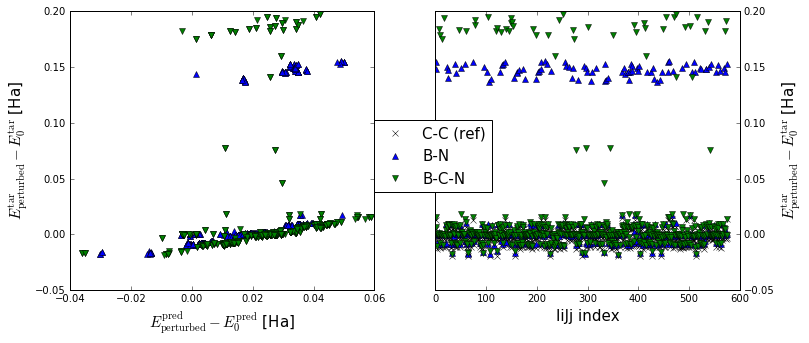

In [21]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
#fig = plt.figure(figsize=(8, 3))
#ax1 = fig.add_subplot(211)
ax1.plot(dE_BN1_prd, dE_BN1_tar, ls='', marker='^', label='B-N')
ax1.plot(dE_BN2_prd, dE_BN2_tar, ls='', marker='v', label='B-C-N')
#ax1.legend(loc=2)
ax1.set_xlabel(r'$E_{\rm perturbed}^{\rm pred} - E_0^{\rm pred}$ [Ha]', fontsize=15)
ax1.set_ylabel(r'$E_{\rm perturbed}^{\rm tar} - E_0^{\rm tar}$ [Ha]', fontsize=15)

#ax2 = fig.add_subplot(221)
ax2.plot(dE_ref, ls='', marker='x', color='k', label='C-C (ref)')
ax2.plot(dE_BN1_tar, ls='', marker='^', label='B-N')
ax2.plot(dE_BN2_tar, ls='', marker='v', label='B-C-N')
ax2.set_ylabel(r'$E_{\rm perturbed}^{\rm tar} - E_0^{\rm tar}$ [Ha]', fontsize=15)
ax2.set_xlabel('IiJj index', fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend(loc=(-0.2, 0.35), fontsize=15, numpoints=1)

There are obviouly two groups of $\Delta E^{\rm tar} > 1.5$ and $\Delta E^{\rm tar} \approx 0$. It could be the case where where perturbation involves prediction from a C-C bond to C-N, C-B, or B-N bond.

There is an issue of the data I have at hand. That is there are some perturbation with $\Delta E^{\rm ref} < 0$. This implies my starting perfect hony cone structrue for graphene is not optimized. This could also be related to finite size effect from my sheet-sheet interaction between periodic images. At the moment there is only a 5 Angstrom distance.

It is also meaningfull to check to predictive error on each group

(0.18, 0.2)

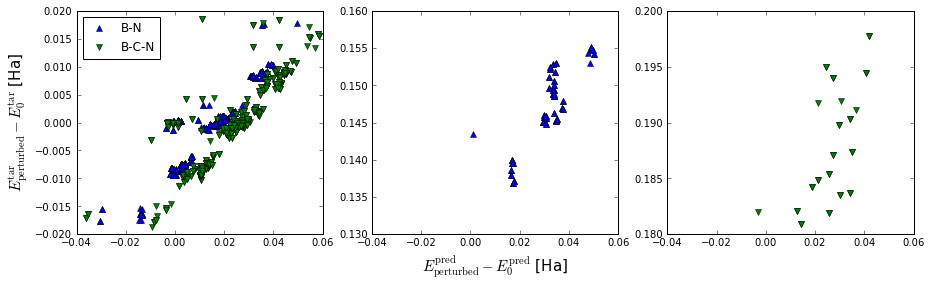

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15,4))
ax1.plot(dE_BN1_prd, dE_BN1_tar, ls='', marker='^', label='B-N')
ax1.plot(dE_BN2_prd, dE_BN2_tar, ls='', marker='v', label='B-C-N')
ax1.legend(loc=2, numpoints=1)
ax1.set_xlabel(r'$E_{\rm perturbed}^{\rm pred} - E_0^{\rm pred}$ [Ha]', fontsize=15, position=(1.7, 0))
ax1.set_ylabel(r'$E_{\rm perturbed}^{\rm tar} - E_0^{\rm tar}$ [Ha]', fontsize=15)
ax1.set_ylim(-0.02,0.02)

ax2.plot(dE_BN1_prd, dE_BN1_tar, ls='', marker='^', label='B-N')
ax2.set_ylim(0.13,0.16)

ax3.plot(dE_BN2_prd, dE_BN2_tar, ls='', marker='v', label='B-C-N', color='green')
ax3.set_ylim(0.18,0.20)

# Analysis: Hessian matrix

In [117]:
# construct Hessian matrix
# convert i, j, I, J (4D array) to Ii, Jj (2D array) for diagonalization

def Hessian_from_list(element_list, job_list=job_list):
    
    assert (3*mol_ref.N)**2 == len(job_list) - 1
    N = np.sqrt(len(job_list) - 1).astype(int)
    
    Hessian = np.zeros([N, N])
    
    for s in range(N**2):
        
        job = job_list[s + 1]

        # 4D index
        [[i, j], [I, J]] = job

        # 2D index
        a = 3 * I + i
        b = 3 * J + j
        
        # assign matrix element to the corresponding location
        Hessian[a, b] = element_list[s]
        
    return Hessian

In [118]:
Hessians_tar = [Hessian_from_list(dE_BN1_tar), Hessian_from_list(dE_BN2_tar)]
Hessians_prd = [Hessian_from_list(dE_BN1_prd), Hessian_from_list(dE_BN2_prd)]

In [121]:
def Hessians_plot_2x2(Hessians, ax1, ax2, ax3, ax4):
    """Plot Hessian matrix as heatmap with corresponding molecule figures"""
    
    vmin, vmax = np.nanmin([Hessians]), np.nanmax([Hessians])
    
    atom_labels = [[], []]
    mol_tar_list = [mol_BN1, mol_BN2]
    for i in range(len(mol_tar_list)):
        mol = mol_tar_list[i]
        atom_labels[i] = [
            '%s%d' % (mol.type_list[j], j+1) for j in range(mol.N)
        ]
    
    im = ax1.imshow(Hessians[0], interpolation='nearest', vmin=vmin, vmax=vmax)
    im = ax2.imshow(Hessians[1], interpolation='nearest', vmin=vmin, vmax=vmax)
    
    cax = fig.add_axes([0.95, 0.55, 0.02, 0.3])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(r'$\partial^2 E\times \Delta R_I\Delta R_J$ [Ha]', fontsize=15)
    ax1.set_title('B-N', fontsize=15)
    ax2.set_title('B-C-N', fontsize=15)
    
    ax1.set_xticks(range(1, 24, 3))
    ax1.set_yticks(range(1, 24, 3))
    ax2.set_xticks(range(1, 24, 3))
    ax2.set_yticks(range(1, 24, 3))
    
    ax1.set_xticklabels(atom_labels[0], fontsize=12)
    ax1.set_yticklabels(atom_labels[0], fontsize=12)
    ax2.set_xticklabels(atom_labels[1], fontsize=12)
    ax2.set_yticklabels(atom_labels[1], fontsize=12)
    
    # 'BN1.png' and 'BN2.png' are generated by RDKit as svg data
    # then converted into png by cairosvg
    BN1_img = mtp.image.imread('BN1.png')
    ax3.imshow(BN1_img)
    ax3.axis('off')

    BN2_img = mtp.image.imread('BN2.png')
    ax4.imshow(BN2_img)
    ax4.axis('off')
    

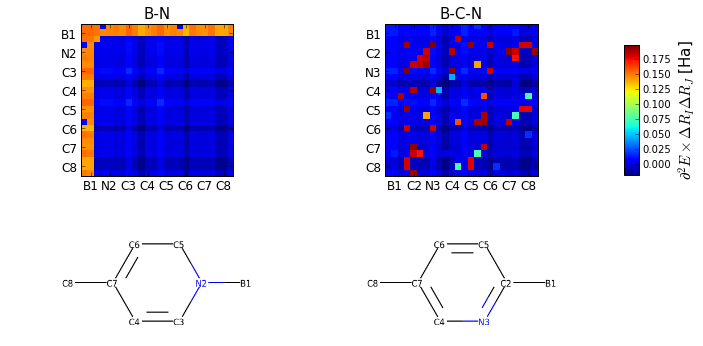

In [122]:
# Hessian matrix for BN1: B1-N2 and BN2: B1-C2-N3
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(10, 6))
Hessians_plot_2x2(Hessians_tar, ax1, ax2, ax3, ax4)

For B-X bonds, tar ~ fit = a*prd + b
R=0.50, MSE=2.60E-03 [Ha], MAE=2.01E-03 [Ha], a=0.45, b=0.13 [Ha]

For C-C and N-C bonds
R=0.66, MSE=2.42E-03 [Ha], MAE=1.59E-03 [Ha], a=0.45, b=-0.01 [Ha]


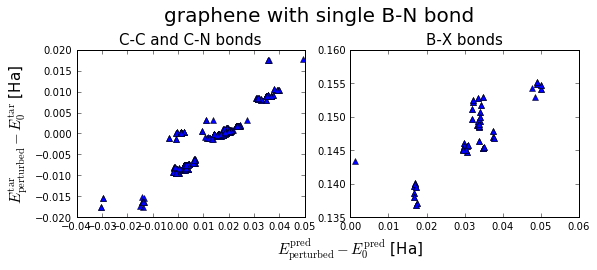

In [76]:
def segment_fit(prd, tar, mask, ax=None):
    
    """
    return (R2, mse, mae), (a, b)
    a * prd + b = tar
    """
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.plot(prd[mask], tar[mask], ls='', marker='^')
    fit = qtk.ML.l2_fit(prd[mask], tar[mask])
    a,b = np.polyfit(prd[mask], tar[mask], 1)
    R2, mse, mae = qtk.ML.error_measure(tar[mask], fit)
    return R2, mse, mae, a, b, fit


# filter out failed predictions (4 out of 576 due to wavefunction IO error)
dE_BN1_prd_finite = dE_BN1_prd[np.isfinite(dE_BN1_prd)]
dE_BN1_tar_finite = dE_BN1_tar[np.isfinite(dE_BN1_prd)]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 3))

mask_BN1 = dE_BN1_tar > 0.1
print "For B-X bonds, tar ~ fit = a*prd + b"
R2, MSE, MAE, a, b, dE_BN1_gp1_fit = segment_fit(dE_BN1_prd, dE_BN1_tar, mask_BN1, ax=ax2)
print "R=%4.2f, MSE=%8.2E [Ha], MAE=%8.2E [Ha], a=%4.2f, b=%4.2f [Ha]" % (R2, MSE, MAE, a, b)
print 
mask_BN1 = dE_BN1_tar_finite <= 0.1
print "For C-C and N-C bonds"
R2, MSE, MAE, a, b, dE_BN1_gp2_fit = segment_fit(dE_BN1_prd_finite, dE_BN1_tar_finite, mask_BN1, ax=ax1)
print "R=%4.2f, MSE=%8.2E [Ha], MAE=%8.2E [Ha], a=%4.2f, b=%4.2f [Ha]" % (R2, MSE, MAE, a, b)

ax1.set_xlabel(r'$E_{\rm perturbed}^{\rm pred} - E_0^{\rm pred}$ [Ha]', fontsize=15, x=1.2)
ax1.set_ylabel(r'$E_{\rm perturbed}^{\rm tar} - E_0^{\rm tar}$ [Ha]', fontsize=15)
ax1.set_title('C-C and C-N bonds', fontsize=15)
ax2.set_title('B-X bonds', fontsize=15)
fig.suptitle('graphene with single B-N bond', fontsize=20, y=1.1)

Even with larger predictin error for perturbations involve B-C bond, the correlation between $E^{\rm pred}$ and $E^{\rm tar}$ for perturbations involve B-C bond are similar to others. Linear fit, $E^{\rm tar}\approx a E^{\rm pred} + b$, gives the same slope $a=0.45$ for all perturbation. The only difference is in the intercept, $b=0.13$ Hartree for perturbations involve B-C bond and $b=-0.01$ Hartree for others. Moreover, the linear fit gives similar predictive performance of mean absolute error (MAE) 0.002 and 0.003 respectively.

# Correction test: Spectrum of fitted Hessian matrix

**Motivation**: Since we know the reason for large alchemical prediction error is because the perturbation on N or B is estimated by wavefunction from pure graphene. And we also know that even at larger prediction error for the element involving perturbation to B or N, the correlation between $E^{\rm pred}$ and $E^{\rm tar}$ is almost identical to the elements of perturbations involve only C. 

If this behaviour can be observed of all possible doping configurations, A much more accurate Hessian matrix can therefore be obtained. For example, a small set of full DFT evaluations for the perturbations  can be used as a calibration set for fitting. Then, the fitting parameters are applied to all other alchemical predictions. However, even if that works, there are still a small prection error of MAE=0.002 Ha for the more accurate fitted Hessian matrix. 

If we assume a fitted Hessian can be obtained, the predition error of should not be smaller than MAE=0.002 Ha. The analysis below can be consitered as the error lower bound this approach.

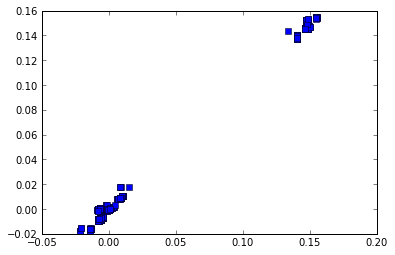

In [88]:
# construct a fitted Hessian matrix element list
dE_BN1_fit = np.zeros(dE_BN1_prd.shape)

# mask for different groupts
mask_gp1 = dE_BN1_tar > 0.1
mask_gp2 = dE_BN1_tar <= 0.1
mask_finite = np.isfinite(dE_BN1_prd)
mask_nan = np.isnan(dE_BN1_prd)

dE_BN1_fit[mask_gp1] = dE_BN1_gp1_fit
dE_BN1_fit[mask_gp2 * mask_finite] = dE_BN1_gp2_fit

# for the moment, failed prediction are simply set to zero error.
# afterall 4 entries out of 576 should not affect too much
dE_BN1_fit[mask_nan] = dE_BN1_tar[mask_nan]

plt.plot(dE_BN1_fit, dE_BN1_tar, ls='', marker='s')

In [142]:
def Hessian_plot(Hessian, ax=None, atom_labels=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    vmin, vmax = np.nanmin(Hessian), np.nanmax(Hessian)
    ax.imshow(Hessian, interpolation='nearest', vmin=vmin, vmax=vmax)
    
    if atom_labels is not None:
        ax.set_xticks(range(1, 24, 3))
        ax.set_yticks(range(1, 24, 3))
        ax.set_xticklabels(atom_labels, fontsize=12)
        ax.set_yticklabels(atom_labels, fontsize=12)

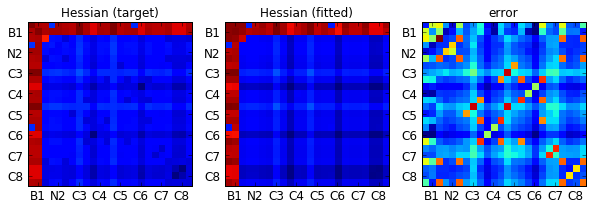

In [143]:
BN1_labels = ['%s%d' % (mol_BN1.type_list[j], j+1) for j in range(mol_BN1.N)]

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 3))
Hessian_fit = Hessian_from_list(dE_BN1_fit)
Hessian_plot(Hessian_fit, ax=ax1, atom_labels = BN1_labels)
Hessian_plot(Hessians_tar[0],ax=ax2,atom_labels = BN1_labels)
Hessian_plot(Hessians_tar[0] - Hessian_fit, ax=ax3, atom_labels = BN1_labels)
ax1.set_title(r'Hessian (target)')
ax2.set_title(r'Hessian (fitted)')
ax3.set_title(r'error')

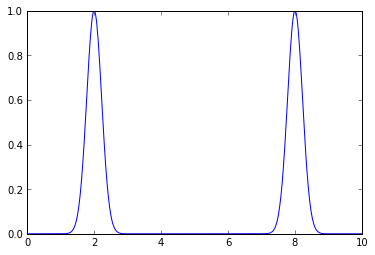

In [187]:
signal = np.array([2,8])
sigma = 0.1
x = np.linspace(0, 10, 500)

plt.figure()
plt.plot(x, y)

In [264]:
W_tar, V_tar = np.linalg.eigh(Hessians_tar[0])
W_fit, V_fit = np.linalg.eigh(Hessian_fit)

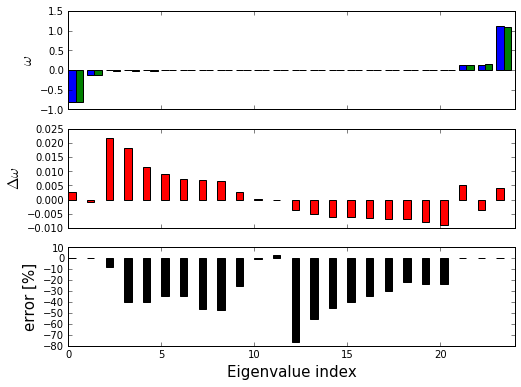

In [265]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax1.bar(range(24), W_tar, 0.4)
ax1.bar(np.array(range(24))+0.4, W_fit, 0.4)
ax1.set_xlim(0, 24)
ax1.set_ylabel(r'$\omega$', fontsize=15)

ax2.bar(range(24), (W_tar - W_fit) , 0.4, color='r')
ax2.set_xlim(0, 24)
ax2.set_ylabel(r'$\Delta\omega$', fontsize=15)

ax3.bar(range(24), (W_tar - W_fit)/W_tar , 0.4, color='k')
ax3.set_xlim(0, 24)
ax3.set_ylabel(r'error [%]', fontsize=15)

ax3.set_xlabel('Eigenvalue index', fontsize=15)

# RDKit utilities to generate 2D figures

In [27]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import rdDepictor
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
import svgutils.compose as sc
from cairosvg import svg2png

BN1 = Chem.MolFromSmiles('[B]N1[C]=[C]C(=[C][CH]1)[C]')
BN2 = Chem.MolFromSmiles('[B]c1n[c]c([c][c]1)[C]')

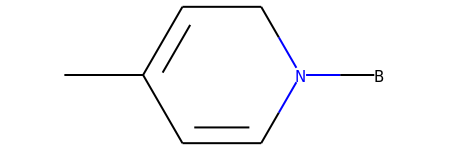

In [28]:
BN1

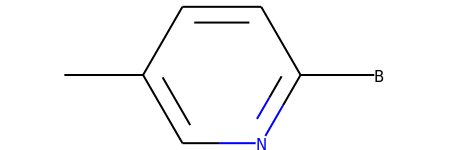

In [29]:
BN2

In [30]:
def moltosvg(mol,label_list,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    opts = drawer.drawOptions()
    
    for i in range(len(label_list)):
        label = label_list[i]
        opts.atomLabels[i] = label
    
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

In [31]:
# RDKit reordered the atoms
# proper ordering is hardcoded
def get_labels(mol):
    labels = []
    for i in range(mol.N):
        labels.append('%s%d' % (mol.type_list[i], i+1))
    labels = np.array(labels)
    label_keys = [0, 1, 2, 3, 6, 5, 4, 7]
    return labels[label_keys]

In [32]:
BN1_labels = get_labels(mol_BN1)
svg = SVG(moltosvg(BN1, BN1_labels))
svg2png(bytestring=svg.data,write_to='BN1.png')

In [33]:
BN2_labels = get_labels(mol_BN2)
svg = SVG(moltosvg(BN2, BN2_labels))
svg2png(bytestring=svg.data,write_to='BN2.png')